# Prototypical Generative Model (PGM) training

In [1]:
%load_ext autoreload
%autoreload 2

import os

os.environ["WANDB_NOTEBOOK_NAME"] = "proto_gen_model.ipynb"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.3"
# Don't turn on deterministic ops unless in need of pain
# os.environ["XLA_FLAGS"] = "--xla_gpu_deterministic_ops=true"

import numpy as np

import jax
import jax.random as random
import jax.numpy as jnp

import flax
flax.config.update('flax_use_orbax_checkpointing', True)
from flax.training import checkpoints

import ciclo
import wandb 

from clu import parameter_overview
from clu import deterministic_data

from absl import logging
logging.set_verbosity(logging.INFO)

# set save plot face color to be white
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["savefig.facecolor"] = "white"

from src.transformations import transform_image
from experiments.configs.pgm_mnist import get_config
from src.utils.input import get_data
from src.models.transformation_inference_model import TransformationInferenceNet, create_transformation_inference_state, make_transformation_inference_train_and_eval
from src.utils.proto_plots import plot_proto_model_training_metrics
from src.models.transformation_generative_model import TransformationGenerativeNet, make_transformation_generative_train_and_eval, create_transformation_generative_state
from src.models.utils import reset_metrics
from src.utils.plotting import rescale_for_imshow
from src.utils.training import custom_wandb_logger


/home/sp2058/miniconda3/envs/inv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/sp2058/miniconda3/envs/inv/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
I0000 00:00:1703197731.043543  923050 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [2]:
ANGLE = 180
config = get_config(f"{ANGLE}")

In [3]:
print((3 * config.model.generative.num_bins + 1) * len(config.model.generative.bounds), config.model.generative.conditioner.hidden_dims[-1])
# Note, we probably want the first number to be smaller than the second number. Haven't tested this yet.

65 256


In [21]:
run = wandb.init(
    project="iclr2024experiments",
    # entity="invariance-learners",
    entity = "shreyaspadhy",
    config=config.to_dict(),
    mode="online",
    notes="",
    name=None,
    settings=wandb.Settings(code_dir="../"),
)

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7fea606b26d0>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7ff1106288d0, raw_cell="run = wandb.init(
    project="iclr2024experiments.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2Bcl/home/sp2058/learning-invariances/notebooks/proto_gen_model.ipynb#W4sdnNjb2RlLXJlbW90ZQ%3D%3D>,),kwargs {}:


TypeError: _WandbInit._resume_backend() takes 1 positional argument but 2 were given

In [22]:
rng = random.PRNGKey(config.seed)
data_rng, proto_init_rng, gen_init_rng, proto_state_rng, gen_state_rng = random.split(rng, 5)

## Get data

In [23]:
jax.local_device_count()

1

In [24]:
train_ds, val_ds, _ = get_data(config, data_rng)

INFO:absl:Load dataset info from /home/sp2058/tensorflow_datasets/mnist/3.0.1
INFO:absl:Fields info.[citation, splits, supervised_keys, module_name] from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset mnist (/home/sp2058/tensorflow_datasets/mnist/3.0.1)
INFO:absl:Constructing tf.data.Dataset mnist for split _EvenSplit(split='train[10000:]', index=0, count=1, drop_remainder=False), from /home/sp2058/tensorflow_datasets/mnist/3.0.1
INFO:absl:Features before preprocessing: {'image': 'uint8[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op ValueRange(vmin=-1, vmax=1, in_min=0, in_max=255.0, clip_values=False, key='image', key_result=None):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op RandomRotate(θ_min=-3.141592653589793, θ_max=3.141592653589793, fill_mode='nearest', fill_value=-1, key='image', key_result=None, rng_key='rng'):
{'image': 'float32[28, 28, 1]', 'label': '

# TransformationInference Network (Prototype inference)

## Setup TrainState and NN

In [25]:
proto_model = TransformationInferenceNet(**config.model.inference.to_dict())

variables = proto_model.init({'params': proto_init_rng, 'sample': proto_init_rng}, jnp.empty((28, 28, 1)), train=False)

parameter_overview.log_parameter_overview(variables)

INFO:absl:
+--------------------------+-------------+---------+-----------+--------+
| Name                     | Shape       | Size    | Mean      | Std    |
+--------------------------+-------------+---------+-----------+--------+
| params/Dense_0/bias      | (1024,)     | 1,024   | 0.0       | 0.0    |
| params/Dense_0/kernel    | (784, 1024) | 802,816 | -1.33e-05 | 0.0357 |
| params/Dense_1/bias      | (512,)      | 512     | 0.0       | 0.0    |
| params/Dense_1/kernel    | (1024, 512) | 524,288 | -4.74e-05 | 0.0313 |
| params/Dense_2/bias      | (256,)      | 256     | 0.0       | 0.0    |
| params/Dense_2/kernel    | (512, 256)  | 131,072 | -0.000144 | 0.0443 |
| params/Dense_3/bias      | (128,)      | 128     | 0.0       | 0.0    |
| params/Dense_3/kernel    | (256, 128)  | 32,768  | 6.18e-05  | 0.0625 |
| params/Dense_4/bias      | (5,)        | 5       | 0.0       | 0.0    |
| params/Dense_4/kernel    | (128, 5)    | 640     | 0.0       | 0.0    |
| params/LayerNorm_0/bias  

In [26]:
params = flax.core.freeze(variables["params"])

proto_state = create_transformation_inference_state(params, proto_state_rng, config)

train_step, eval_step = make_transformation_inference_train_and_eval(config, proto_model)

INFO:absl:A polynomial schedule was set with a non-positive `transition_steps` value; this results in a constant schedule with value `init_value`.
INFO:absl:A polynomial schedule was set with a non-positive `transition_steps` value; this results in a constant schedule with value `init_value`.


In [27]:
total_steps = config.inf_steps
proto_final_state, history, _ = ciclo.train_loop(
    proto_state,
    deterministic_data.start_input_pipeline(train_ds),
    {
        ciclo.on_train_step: [
            train_step
        ],
        ciclo.on_reset_step: reset_metrics,
        ciclo.on_test_step: eval_step,
        ciclo.every(1): custom_wandb_logger(run=run)
    },
    test_dataset=lambda: deterministic_data.start_input_pipeline(val_ds),
    epoch_duration=int(total_steps * config.eval_freq),
    callbacks=[
        ciclo.keras_bar(total=total_steps),
        # ciclo.early_stopping("loss_test", patience=total_steps // 10, min_delta=1e-4, mode="min", restore_best_weights=True),
        # ciclo.checkpoint("checkpoint", monitor="loss_test", mode="min", overwrite=True),
    ],
    stop=total_steps + 1,
)

20000/20000 [==============================] - 395s 20ms/step - invertibility_loss: 0.0033 - loss: 0.0563 - x_mse: 0.0560 - η_recon_loss: 0.1273 - invertibility_loss_test: 0.0033 - loss_test: 0.0558 - x_mse_test: 0.0555 - η_recon_loss_test: 0.1264 - label_paired_image_mse_test: 0.3084    - ETA: 37:31 - invertibility_loss: 6.1769e-04 - loss: 0.1537 - x_mse: 0.1537 - η_recon_loss: 0.4812 - invertibility_loss_test: 0.0014 - loss_test: 0.4641 - x_ - ETA: 17:46 - invertibility_loss: 3.5876e-04 - loss: 0.0987 - x_mse: 0.0986 - η_recon_loss: 0.4193 - invertibility_loss_test: 0.0012 - loss_test: 0.2175 -  - ETA: 13:11 - invertibility_loss: 3.4599e-04 - loss: 0.0978 - x_mse: 0.0977 - η_recon_loss: 0.4208 - invertibility_loss_test: 0.0013 - loss_test: 0.2064 - x_mse_test: 0.2063 - η_recon_loss_test: 0.4209 - label_paired_image_mse_test: 0. - ETA: 13:00 - invertibility_loss: 3.4655e-04 - loss: 0.0979 - x_mse: 0.0978 - η_recon_loss: 0.4210 - invertibility_loss_test: 0.0013 - loss_test: 0.2064 - x_

In [28]:
run.finish()

augment_bounds_mult,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
blur_sigma,██▇▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grad_norm,▄▁▂▁▂▂▂▂▄▃▅▂▄█▅▃▅▅▅▅▂▄▃▄▄▃▅▄▂▂▃▃▃▃▃▂▃▄▂▅
lr_inf,▄▆███████▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
lr_σ,▄▅███████▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
train/invertibility_loss,▁▁▁▁▁▁▁▂▂▃▄▅▇████▇██▇▇▇▇▇▇▇▇█▇▇▇▇██▇████
train/loss,█▇▇▇▇▇▄▄▄▃▄▆▅▆▆▅▅▅▄▄▃▄▄▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
train/x_mse,█▇▇▇▇▇▄▄▄▃▄▆▅▆▆▅▅▅▄▄▃▄▃▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
train/η_recon_loss,█████▆▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
valid/invertibility_loss,▁▁▂▃▄▅▅▆▇███▇▇▇▆▇▆▆▅▆▆▆▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
valid/label_paired_image_mse,█▂▂▂▁▁▂▁▁▁▁▂▂▁▂▂▁▁▁▂▂▁▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁


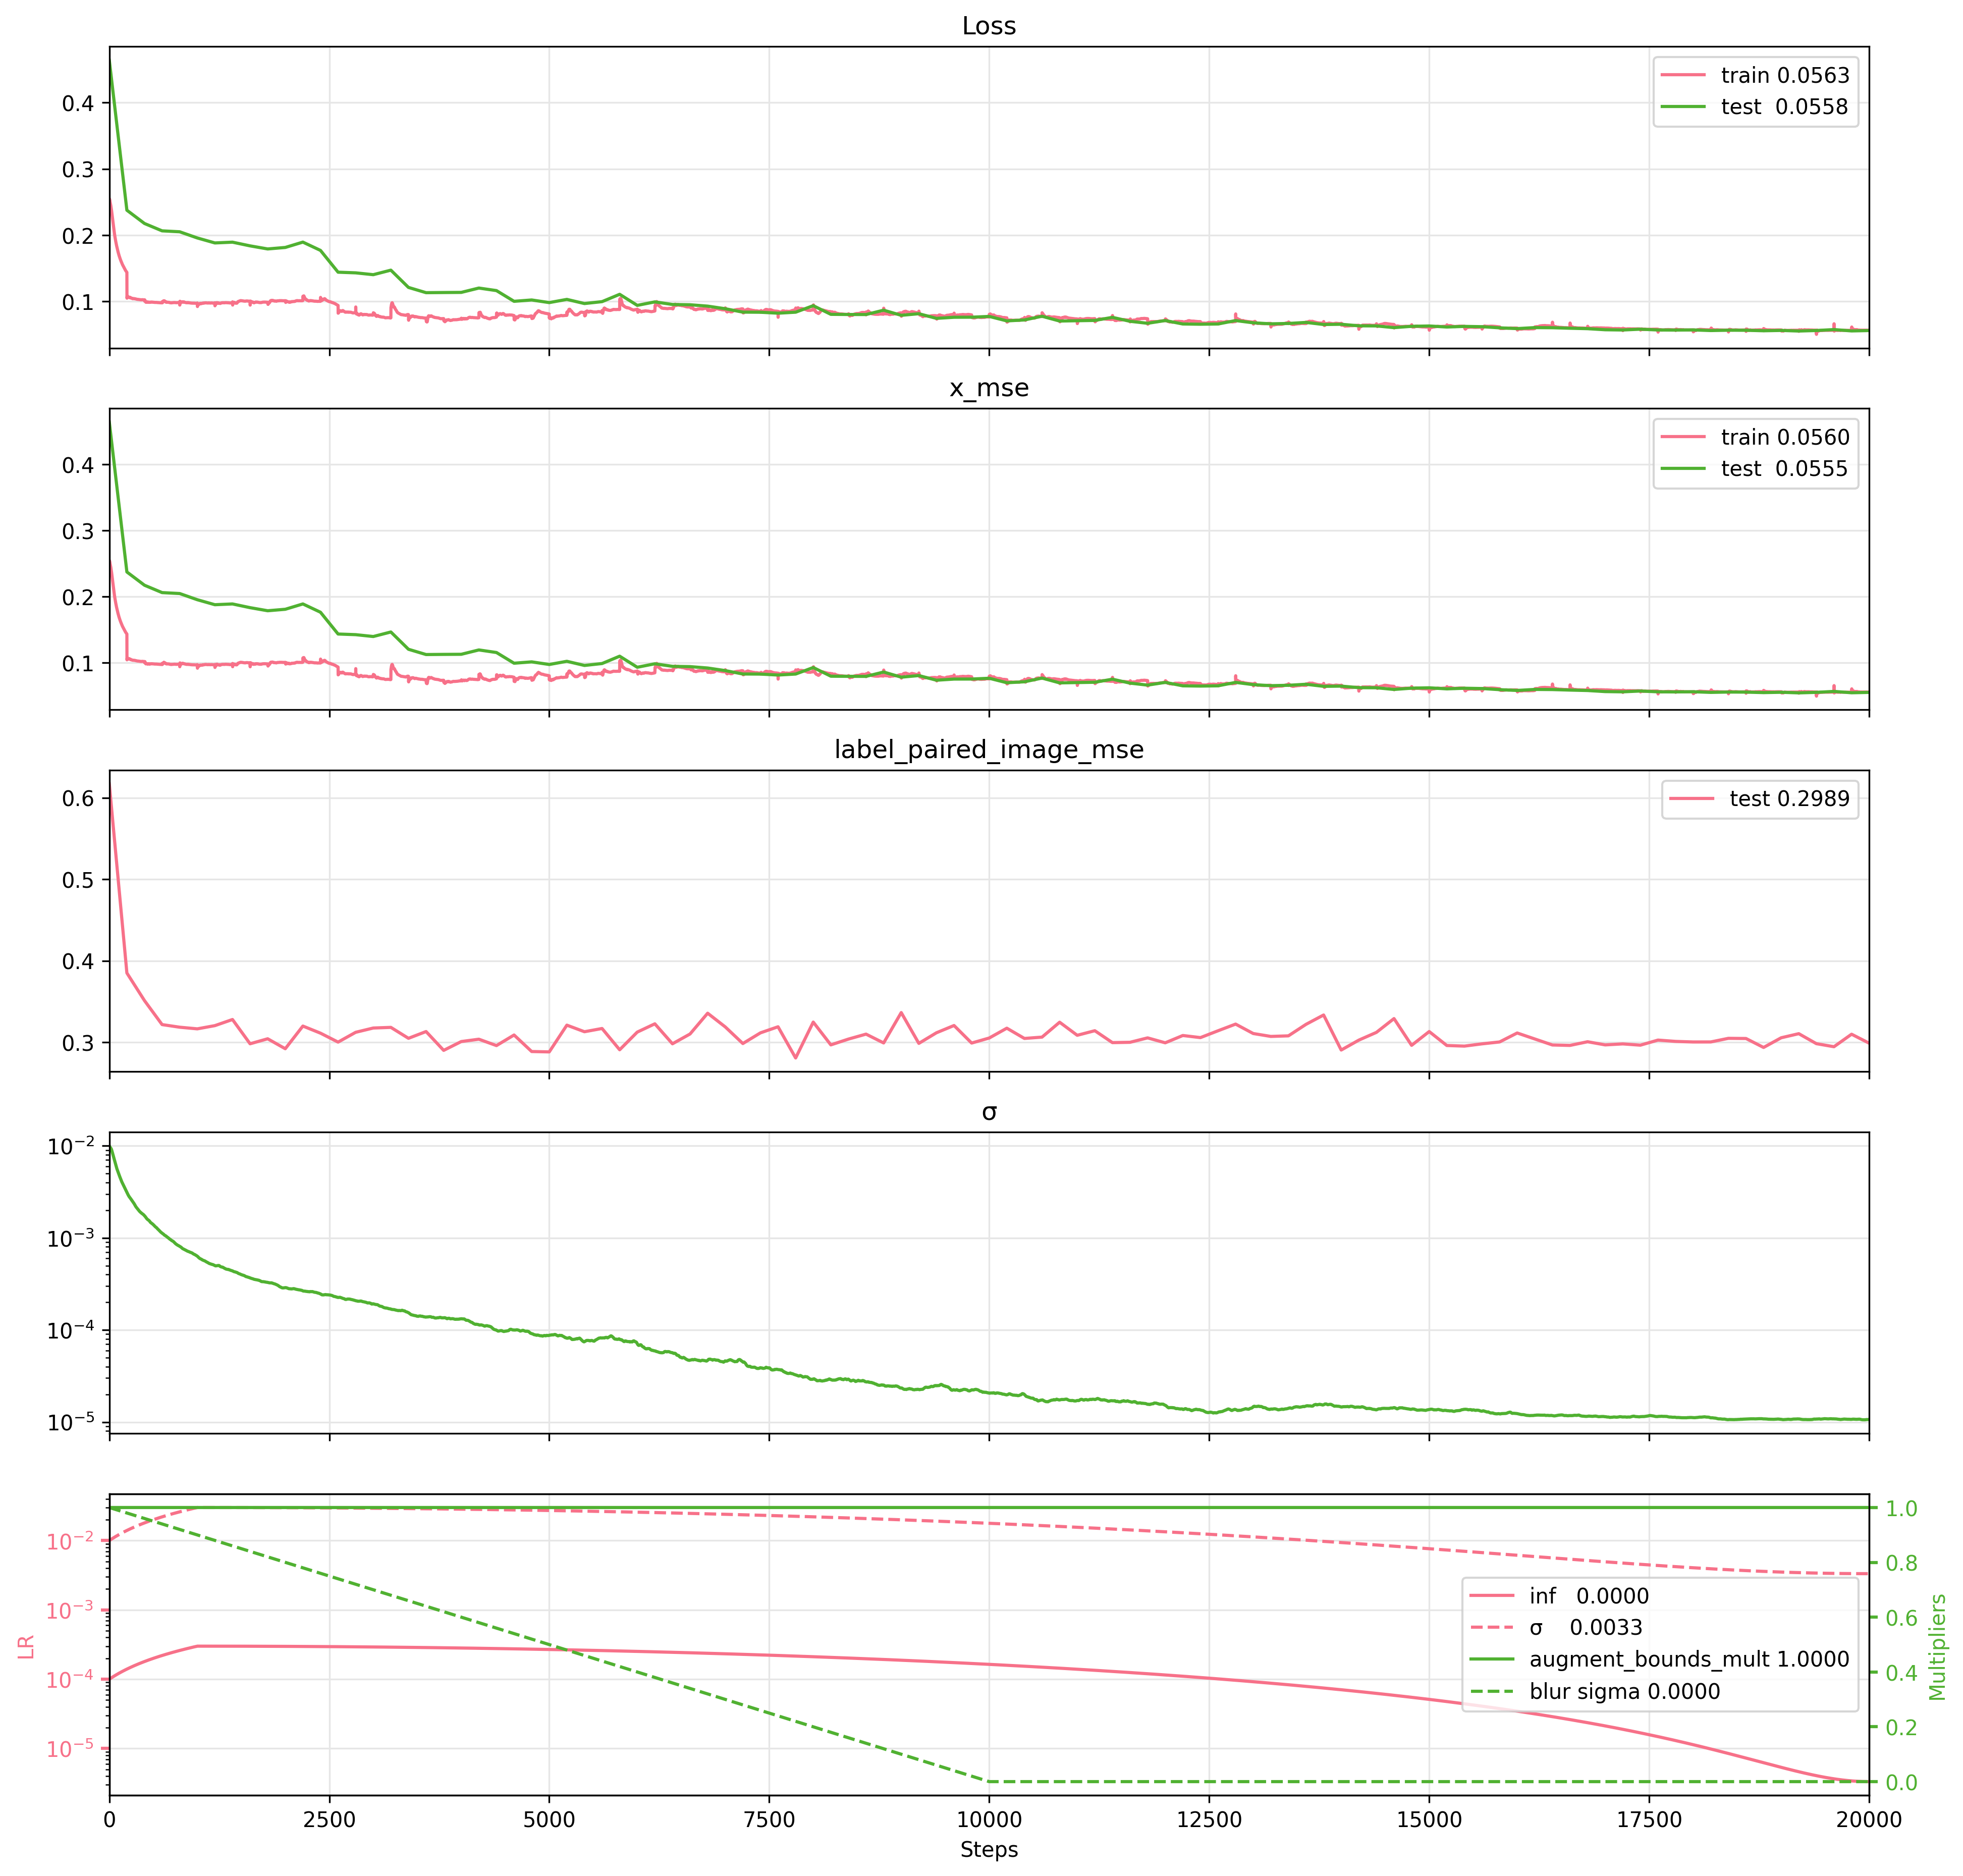

In [29]:
fig = plot_proto_model_training_metrics(history)

In [30]:
jax.nn.softplus(proto_final_state.params['σ_']).mean()

Array(1.0644512e-05, dtype=float32)

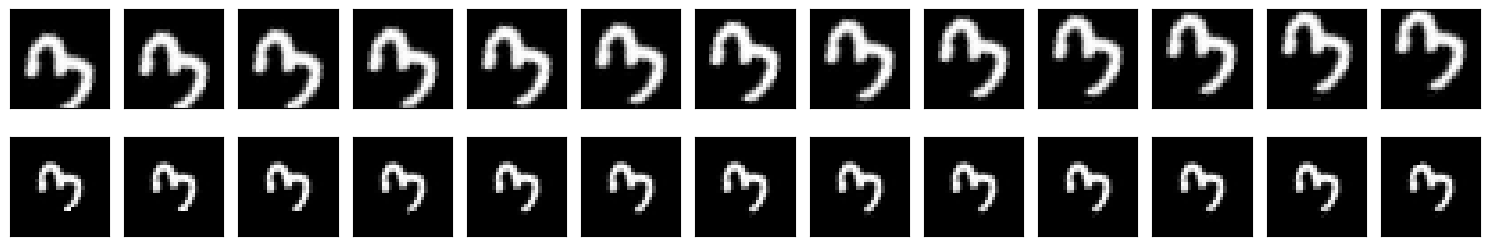

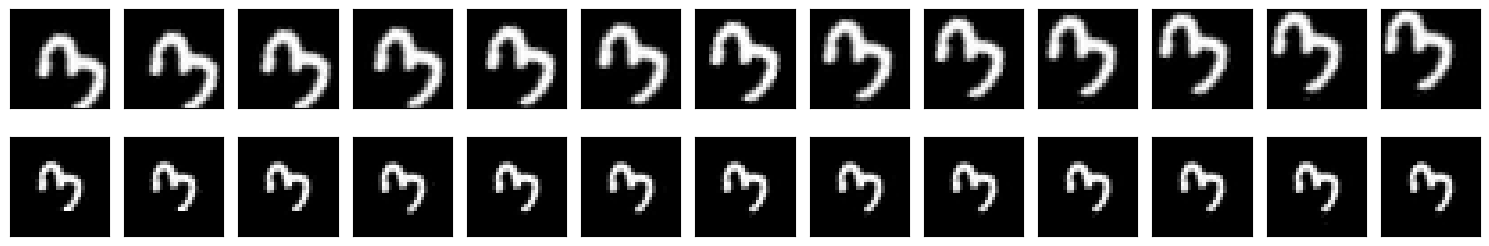

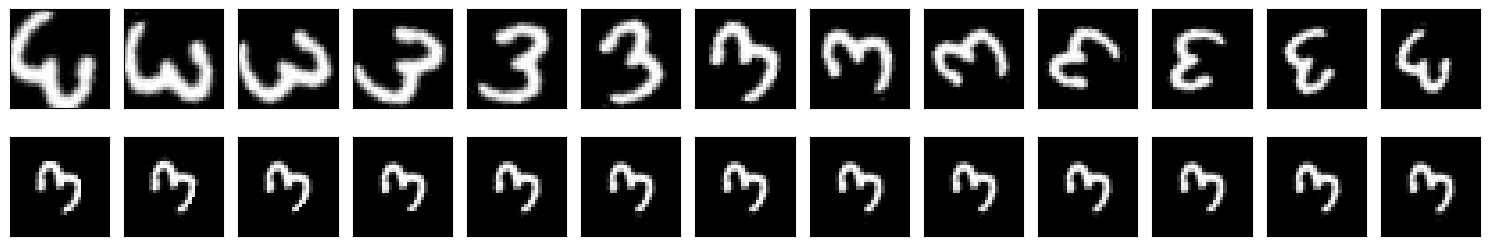

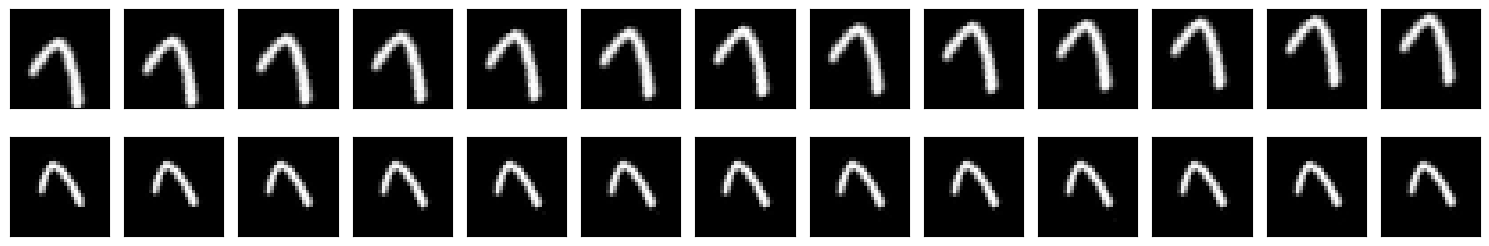

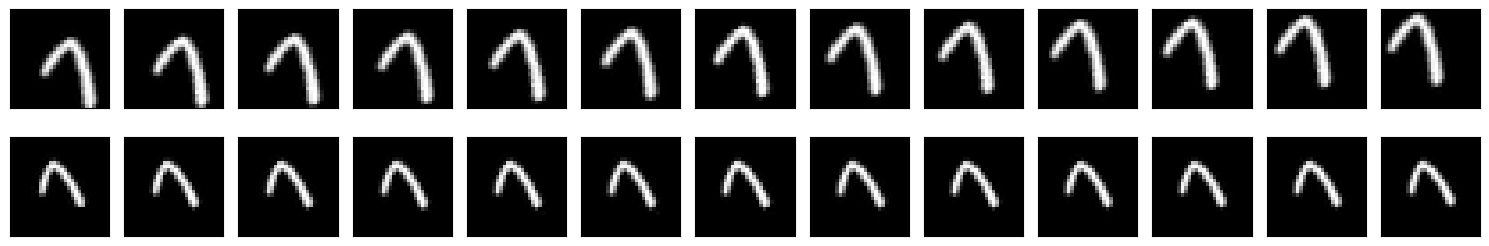

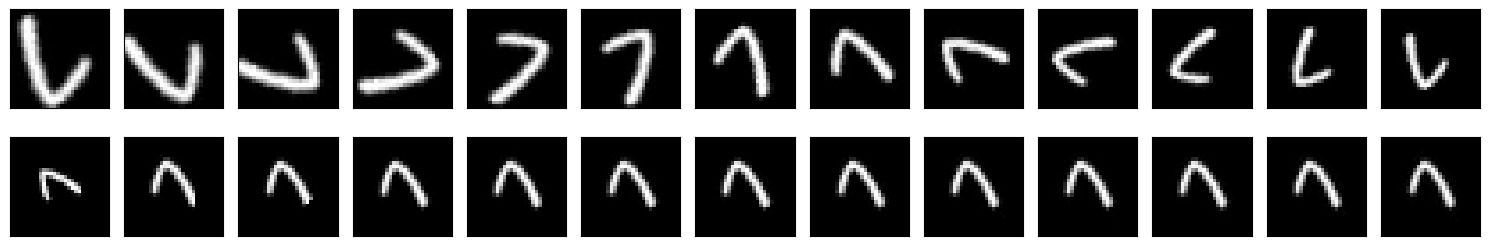

In [31]:
from src.transformations.affine import gen_affine_matrix_no_shear, transform_image_with_affine_matrix


val_iter = deterministic_data.start_input_pipeline(val_ds)
val_batch = next(val_iter)

@jax.jit
def get_prototype(x):
    p_η = proto_model.apply({"params": proto_final_state.params}, x, train=False)
    η = p_η.sample(seed=rng)
    
    transform = proto_model.transform(η).inverse()
    # affine_matrix = gen_affine_matrix_no_shear(η)
    # affine_matrix_inv = jnp.linalg.inv(affine_matrix)
    xhat = transform.apply(x)
    # xhat = transform_image_with_affine_matrix(x, affine_matrix_inv, order=config.interpolation_order)
    return xhat, η

for x_ in [
    val_batch['image'][0][14],
    val_batch['image'][0][12],
]:
    for mask in [
        # jnp.array([0, 0, 1, 0, 0]),
        jnp.array([0, 1, 0, 0, 0]),
        jnp.array([1, 1, 0, 0, 0]),
        # jnp.array([0, 0, 0, 1, 1]),
        jnp.array([1, 1, 1, 1, 1])
    ]:

        transformed_xs = jax.vmap(transform_image, in_axes=(None, 0))(
            x_,
            jnp.linspace(-jnp.array(config.augment_bounds[:5]) * mask, jnp.array(config.augment_bounds[:5]) * mask, 13)
        )

        xhats, ηs = jax.vmap(get_prototype)(transformed_xs)

        fig, axs = plt.subplots(2, len(xhats), figsize=(15, 3))

        for ax, x in zip(axs[0], list(transformed_xs)):
            ax.imshow(rescale_for_imshow(x), cmap='gray')
            ax.set_xticks([])
            ax.set_yticks([])

        for ax, xhat in zip(axs[1], list(xhats)):
            ax.imshow(rescale_for_imshow(xhat), cmap='gray')
            ax.set_xticks([])
            ax.set_yticks([])

        plt.tight_layout()
        plt.show()

# Generative Network

## Define the prototype function

In [32]:
def prototype_function(x, rng):
    η = proto_model.apply({"params": proto_final_state.params}, x, train=False).sample(seed=rng)
    return η

In [33]:
gen_model = TransformationGenerativeNet(**config.model.generative.to_dict())

variables = gen_model.init({'params': gen_init_rng, 'sample': gen_init_rng}, jnp.empty((28, 28, 1)), η=jnp.empty((5,)), train=False)
parameter_overview.log_parameter_overview(variables)

INFO:absl:
+------------------------------------------------+-------------+---------+-----------+--------+
| Name                                           | Shape       | Size    | Mean      | Std    |
+------------------------------------------------+-------------+---------+-----------+--------+
| params/ConditionedConditioner_0/Dense_0/bias   | (256,)      | 256     | 0.0       | 0.0    |
| params/ConditionedConditioner_0/Dense_0/kernel | (261, 256)  | 66,816  | -0.000127 | 0.0619 |
| params/ConditionedConditioner_0/Dense_1/bias   | (256,)      | 256     | 0.0       | 0.0    |
| params/ConditionedConditioner_0/Dense_1/kernel | (256, 256)  | 65,536  | 0.000244  | 0.0627 |
| params/ConditionedConditioner_0/Dense_2/bias   | (65,)       | 65      | 0.0       | 0.0    |
| params/ConditionedConditioner_0/Dense_2/kernel | (256, 65)   | 16,640  | 0.0       | 0.0    |
| params/ConditionedConditioner_1/Dense_0/bias   | (256,)      | 256     | 0.0       | 0.0    |
| params/ConditionedCondition

In [46]:
gen_params = flax.core.freeze(variables["params"])

gen_state = create_transformation_generative_state(gen_params, gen_state_rng, config)

train_step, eval_step = make_transformation_generative_train_and_eval(config, gen_model, prototype_function=prototype_function)

In [48]:
run = wandb.init(
    project="iclr2024experiments",
    # entity="invariance-learners",
    entity="shreyaspadhy",
    config=config.to_dict(),
    mode="online",
    notes="",
    name=None,
    settings=wandb.Settings(code_dir="../"),
)

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7fe9112ef8d0>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7fe9112303d0, raw_cell="run = wandb.init(
    project="iclr2024experiments.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2Bcl/home/sp2058/learning-invariances/notebooks/proto_gen_model.ipynb#X32sdnNjb2RlLXJlbW90ZQ%3D%3D>,),kwargs {}:


TypeError: _WandbInit._resume_backend() takes 1 positional argument but 2 were given

In [49]:
gen_final_state, history, _ = ciclo.train_loop(
    gen_state,
    deterministic_data.start_input_pipeline(train_ds),
    {
        ciclo.on_train_step: [
            train_step
        ],
        ciclo.on_reset_step: reset_metrics,
        ciclo.on_test_step: eval_step,
        ciclo.every(1): custom_wandb_logger(run=run)
    },
    test_dataset=lambda: deterministic_data.start_input_pipeline(val_ds),
    epoch_duration=int(config.gen_steps * config.eval_freq),
    callbacks=[
        ciclo.keras_bar(total=config.gen_steps),
        # ciclo.early_stopping("loss_test", patience=total_steps // 10, min_delta=1e-4, mode="min", restore_best_weights=True),
        # ciclo.checkpoint("checkpoint", monitor="loss_test", mode="min", overwrite=True),
    ],
    stop=config.gen_steps + 1,
)

10000/10000 [==============================] - 205s 20ms/step - log_p_η_x_hat: 6.6446 - loss: -6.1763 - mae: 0.4707 - log_p_η_x_hat_test: 6.4954 - loss_test: -6.0053 - mae_test: 0.49013s - log_p_η_x_hat: 6.6407 - loss: -6.1823 - mae: 0.4670 - log_p_η_x_hat_test: 6.5080 - loss_test: -6.0395 - mae_test: 0.478 - ETA: 3s - log_p_η_x_hat: 6.6418 - loss: -6.1834 - mae: 0.4670 - log_p_η_x_ha


In [38]:
run.finish()

grad_norm,▅█▃▄▅▄▅▃▁▃▃▃▄▃▃▂▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▃▂▂▂▁▂▁▁▁
lr_gen,▃▃▅▇██████▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
mae_loss_mult,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/log_p_η_x_hat,▁▃▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████
train/loss,█▆▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/mae,▁▃▅▆▇▇▇████████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▆▇▆▆▇▆▆▆▆▆
valid/log_p_η_x_hat,▁▅▆▆▇▇▇▇▇▇▇▇▇▇█▇████████████████████████
valid/loss,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid/mae,▁▅▆▆█▇██▇▇▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
grad_norm,4.74743
lr_gen,0.0


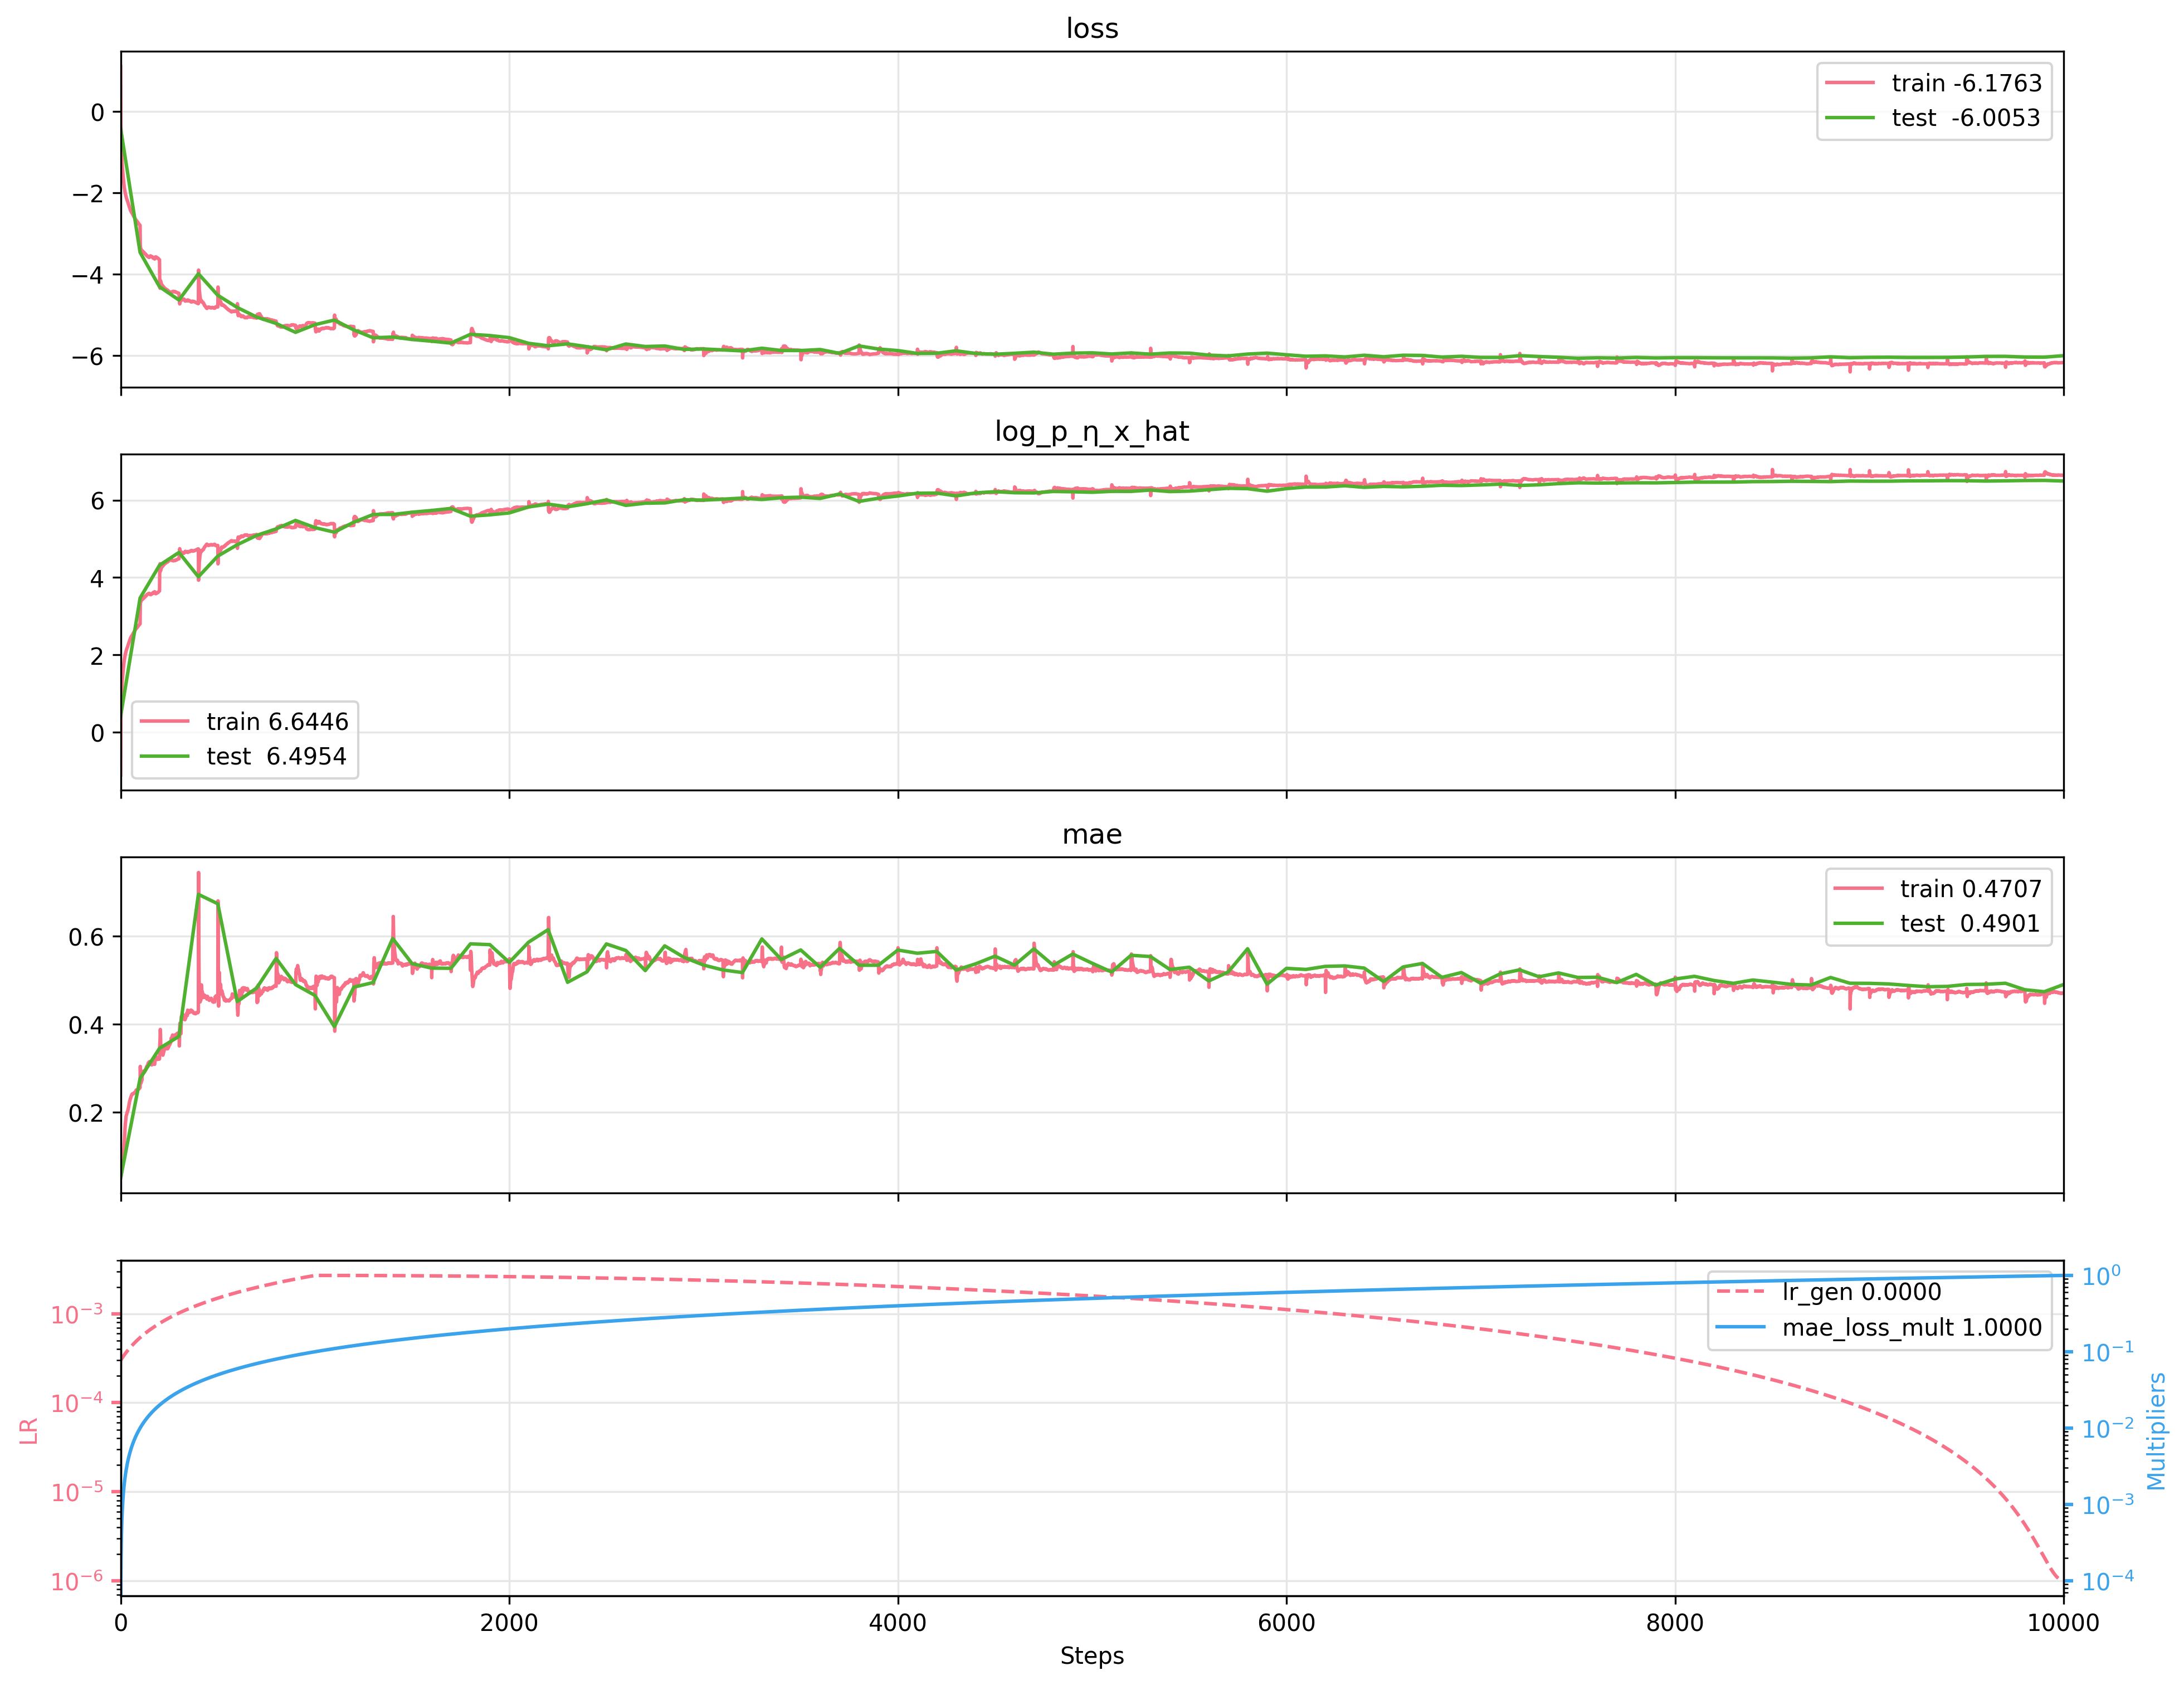

In [50]:
colors = sns.color_palette("husl", 3)

# plot the training history
steps, loss, log_p_η_x_hat, mae, lr_gen,  = history.collect(
    "steps",
    "loss",
    "log_p_η_x_hat",
    "mae",
    "lr_gen"
)
mae_loss_mult = history.collect("mae_loss_mult")
steps_test, loss_test, log_p_η_x_hat_test, mae_test = history.collect(
    "steps", "loss_test", "log_p_η_x_hat_test", "mae_test"
)

n_plots = 4
fig, axs = plt.subplots(
    n_plots, 1, figsize=(15, n_plots * 3.0), dpi=300, sharex=True
)

for train_metric, test_metric, metric_name, ax in zip(
    [loss, log_p_η_x_hat, mae],
    [loss_test, log_p_η_x_hat_test, mae_test],
    ["loss", "log_p_η_x_hat", "mae"],
    axs,
):
    ax.plot(steps, train_metric, label=f"train {train_metric[-1]:.4f}", color=colors[0])
    ax.plot(steps_test, test_metric, label=f"test  {test_metric[-1]:.4f}", color=colors[1])
    ax.legend()
    ax.set_title(metric_name)

# Schedule axis:
lr_ax = axs[-1]
multiplier_ax = lr_ax.twinx()
# par2 = host.twinx()

p1, = lr_ax.plot(steps, lr_gen, "--", label=f"lr_gen {lr_gen[-1]:.4f}", color=colors[0])
p2, = multiplier_ax.plot(
    steps,
    mae_loss_mult,
    label=f"mae_loss_mult {mae_loss_mult[-1]:.4f}",
    color=colors[2]
)
lines = [p1, p2]
lr_ax.legend(lines, [l.get_label() for l in lines])

lr_ax.set_yscale("log")
multiplier_ax.set_yscale("log")
# par2.set_yscale("log")

lr_ax.set_ylabel(f"LR")
# par1.set_ylabel("σ LR")
multiplier_ax.set_ylabel("Multipliers")

lr_ax.yaxis.label.set_color(p1.get_color())
multiplier_ax.yaxis.label.set_color(p2.get_color())
# par2.yaxis.label.set_color(p3.get_color())

tkw = dict(size=4, width=1.5)
lr_ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
multiplier_ax.tick_params(axis='y', colors=p2.get_color(), **tkw)
# par2.tick_params(axis='y', colors=p3.get_color(), **tkw)

axs[-1].set_xlim(min(steps), max(steps))
axs[-1].set_xlabel("Steps")

for ax in axs:
    ax.grid(color=(0.9, 0.9, 0.9))

plt.show()

In [51]:
# best_state = checkpoints.restore_checkpoint(ckpt_dir='checkpoint', target=state)
# best_state.step
gen_final_state.params
gen_model

TransformationGenerativeNet(
    # attributes
    hidden_dims = (1024, 512, 256)
    num_flows = 2
    num_bins = 4
    bounds = (0.25, 0.25, 3.141592653589793, 0.25, 0.25)
    offset = (0.0, 0.0, 0.0, 0.0, 0.0)
    conditioner = {'hidden_dims': (256, 256)}
    ε = 1e-06
    squash_to_bounds = False
    transform = AffineTransformWithoutShear
)

In [52]:
from scipy.stats import gaussian_kde


# function to plot the histograms of p(η|x_hat) in each dimmension
def plot_hists(x, n=10_000):
    # q_H_x = q_H_X.apply(q_H_X_vars, x)
    # ηs_q = canon_functini(seed=random.PRNGKey(0), sample_shape=(n))
    # η = ηs_q[jnp.argmax(log_probs)]
    # TODO: is the argmaxing here necessary? Why not do it in the canon_function?
    η = prototype_function(x, rng)
    transform = gen_model.transform(η).inverse()
    xhat = transform.apply(x, order=config.interpolation_order)

    p_H_x_hat, _ = gen_model.apply({"params": gen_final_state.params}, xhat)
    
    ηs_p = p_H_x_hat.sample(seed=random.PRNGKey(0), sample_shape=(10_000,))

    transform_param_dim = η.shape[0]
    fig, axs = plt.subplots(1, transform_param_dim + 2, figsize=(3*(transform_param_dim+2), 3))

    axs[0].imshow(rescale_for_imshow(x), cmap='gray')
    axs[1].imshow(rescale_for_imshow(xhat), cmap='gray')

    for i, ax in enumerate(axs[2:]):
        x = np.linspace(ηs_p[:, i].min(), ηs_p[:, i].max(), 1000)

        # plot p(η|x_hat)
        ax.hist(ηs_p[:, i], bins=100, density=True, alpha=0.5, color="C0")
        kde = gaussian_kde(ηs_p[:, i])
        ax.plot(x, kde(x), color="C0")

        # make a axvline to plot η, make the line dashed
        ax.axvline(η[i], color="C1", linestyle="--")
        # make a twin axis to plot q(η|x)
        # ax2 = ax.twinx()
        # ax2.hist(ηs_q[:, i], bins=100, density=True, alpha=0.5, color="C1")
        # kde = gaussian_kde(ηs_q[:, i])
        # ax2.plot(x, kde(x), color="C1")

        ax.set_title(f"dim {i}")
        print(x.min(), x.max())
        ax.set_xlim(x.min(), x.max())

    plt.tight_layout()
    plt.show()

-0.17504316568374634 0.18952134251594543
-0.15287834405899048 0.0688064768910408
-3.329528570175171 3.347221612930298
-4.035046100616455 -0.043585874140262604
-0.5969380736351013 -0.07984410971403122


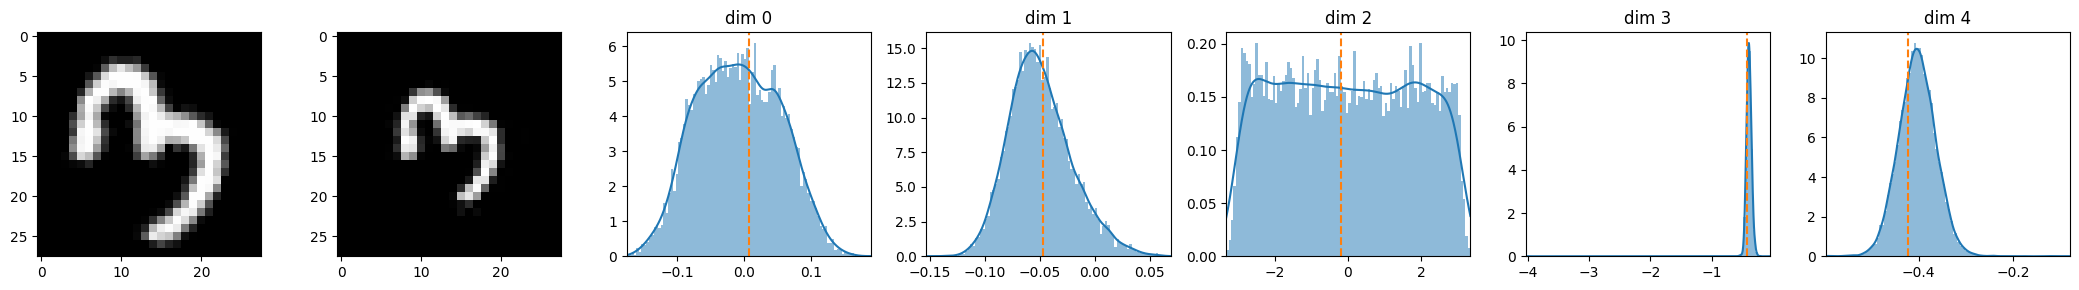

-0.26290446519851685 0.2542014718055725
-0.7201497554779053 0.08657931536436081
-3.0968644618988037 3.411224603652954
-2.3660664558410645 10.075124740600586
-9.34400463104248 0.5724132061004639


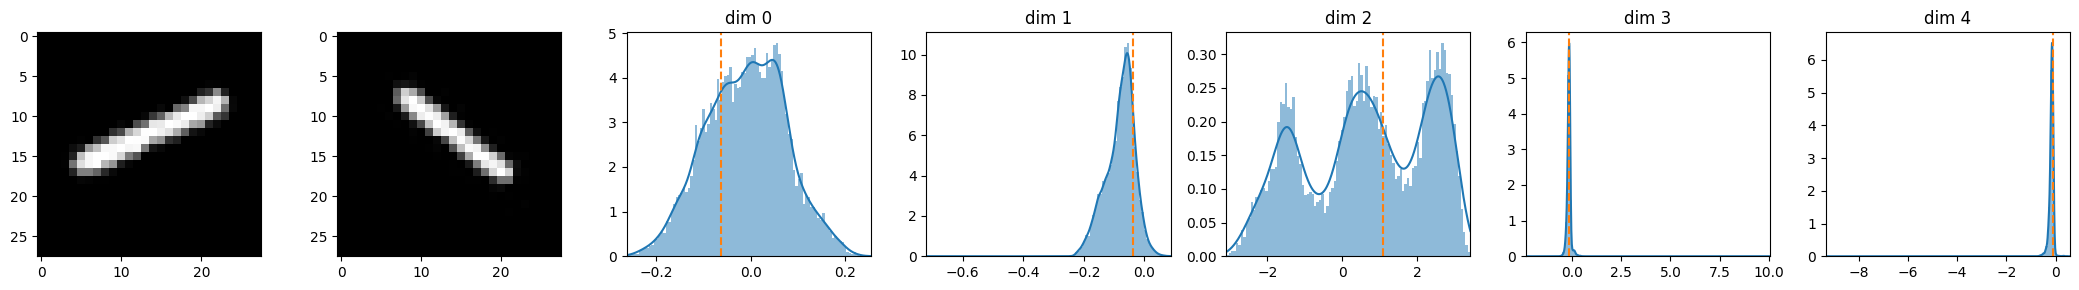

-0.2492363005876541 0.25201737880706787
-0.7142508029937744 0.14288939535617828
-3.3539485931396484 3.5588598251342773
-3.104281187057495 85.27946472167969
-8.96094036102295 0.43006396293640137


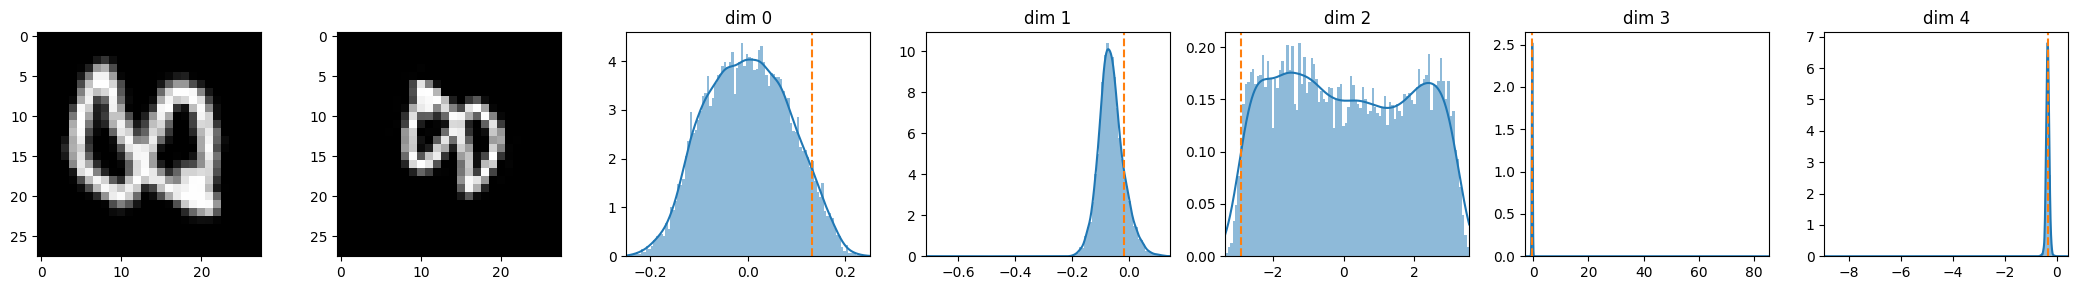

-0.27472177147865295 0.24171626567840576
-0.19853246212005615 0.10223782807588577
-3.0479910373687744 3.7184534072875977
-1.184787631034851 48.145652770996094
-0.5922873616218567 0.08939484506845474


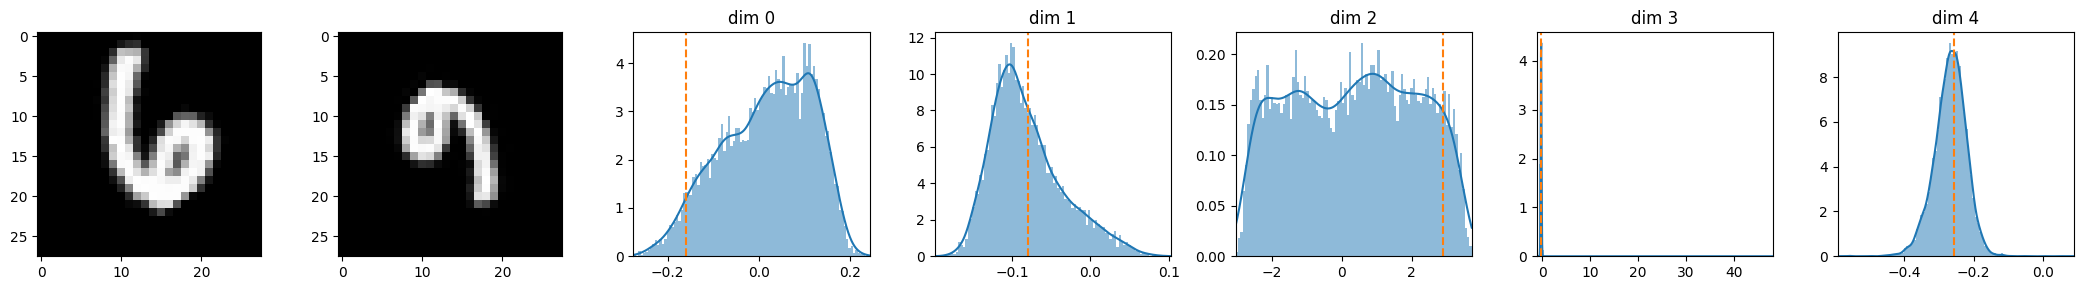

In [53]:
plot_hists(val_batch['image'][0][14], n=1_000)
plot_hists(val_batch['image'][0][1], n=1_000)
plot_hists(val_batch['image'][0][4], n=1_000)
plot_hists(val_batch['image'][0][9], n=1_000)

-0.20322205126285553 0.19305935502052307
-0.15740416944026947 0.0690939798951149
-3.0961248874664307 3.469223737716675
-1.3120759725570679 0.02843010425567627
-0.5784425139427185 0.047246553003787994


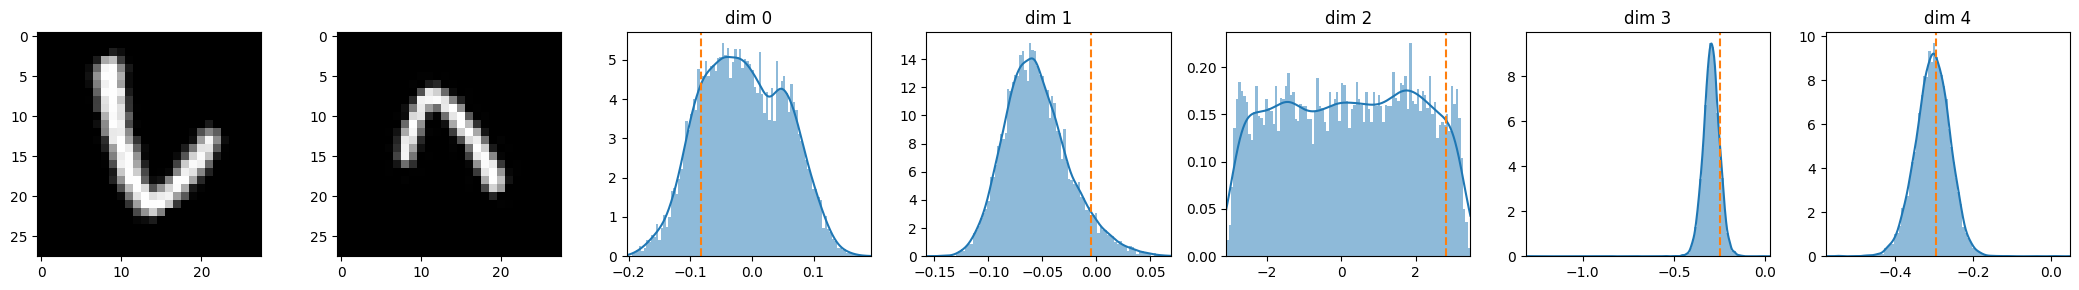

-0.20551876723766327 0.19443176686763763
-0.15889452397823334 0.06951051950454712
-3.096464157104492 3.467334508895874
-1.2766276597976685 0.03254926949739456
-0.5750177502632141 0.050183579325675964


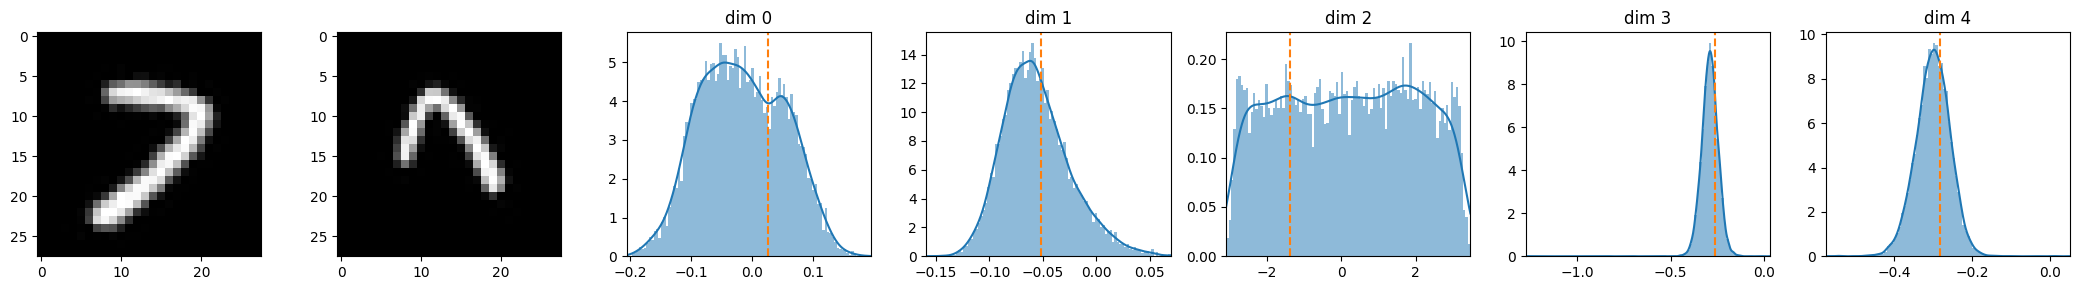

-0.2037898302078247 0.1926228106021881
-0.1577780395746231 0.0692836344242096
-3.0939879417419434 3.4750638008117676
-1.263226866722107 0.03155798092484474
-0.5737122893333435 0.053262218832969666


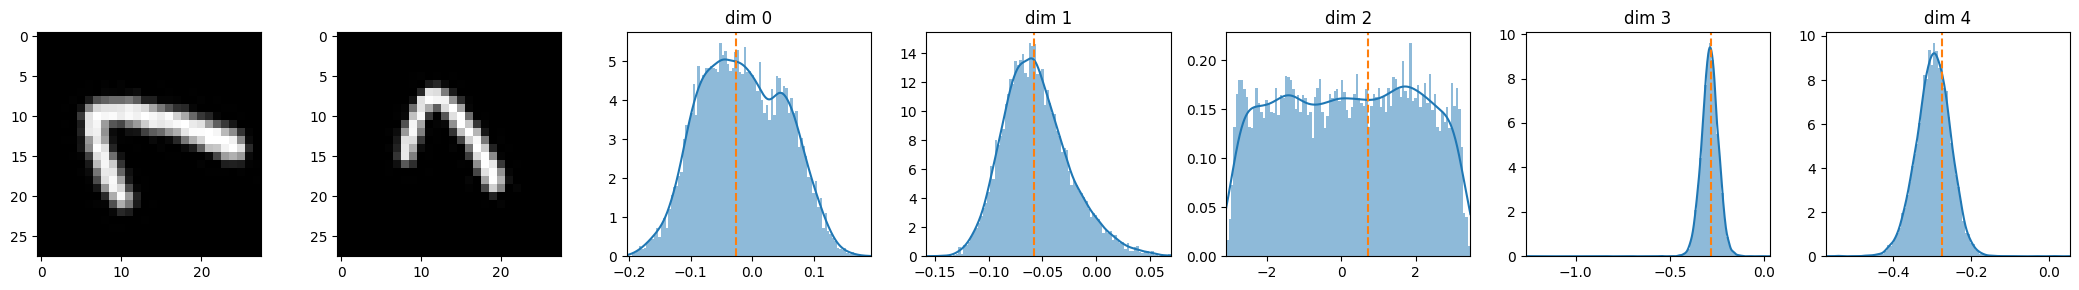

-0.28434357047080994 0.26945361495018005
-0.7377562522888184 0.1468634307384491
-3.3191819190979004 3.6594276428222656
-4.6579742431640625 165.6144256591797
-17.231760025024414 0.5944150686264038


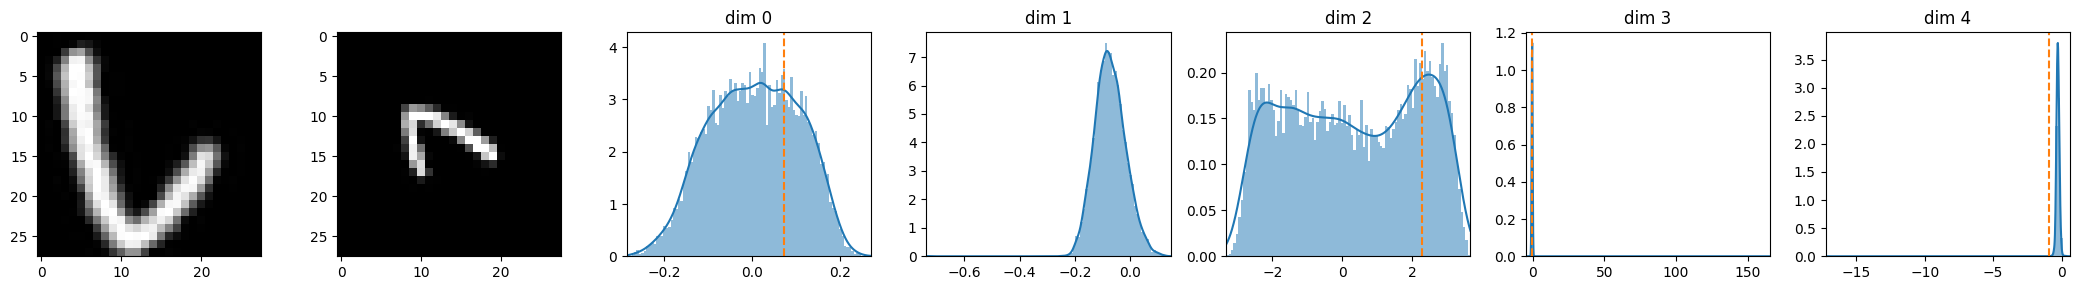

-0.20418989658355713 0.1937708705663681
-0.1578897386789322 0.06991764158010483
-3.0945327281951904 3.470506429672241
-1.2831306457519531 0.030843259766697884
-0.5765579342842102 0.04903831332921982


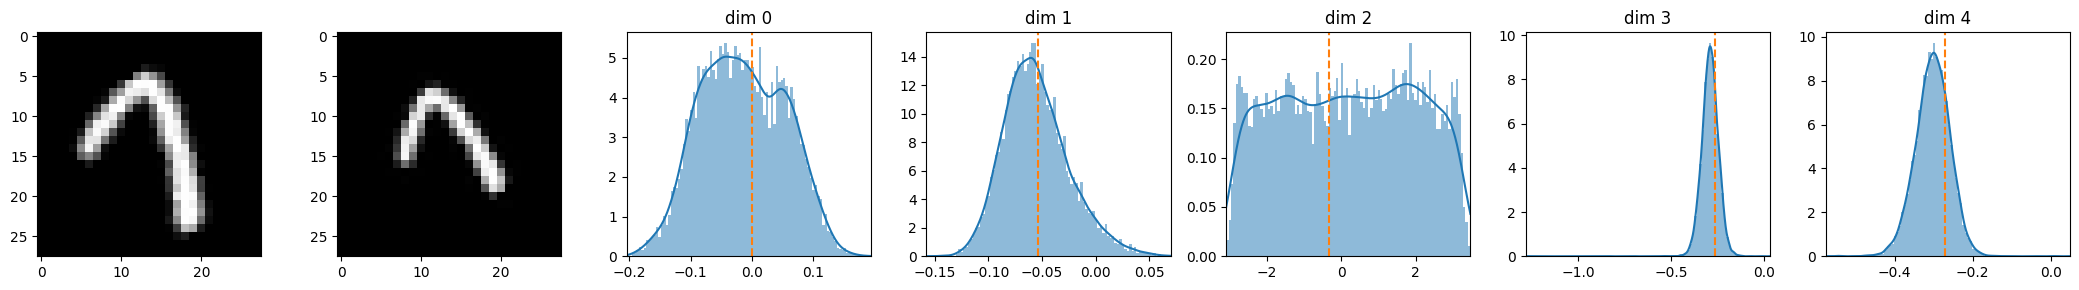

-0.2073313295841217 0.19487138092517853
-0.1579306721687317 0.07798983156681061
-3.069300413131714 3.5106852054595947
-1.099118709564209 0.06493300199508667
-0.5546184778213501 0.09789355099201202


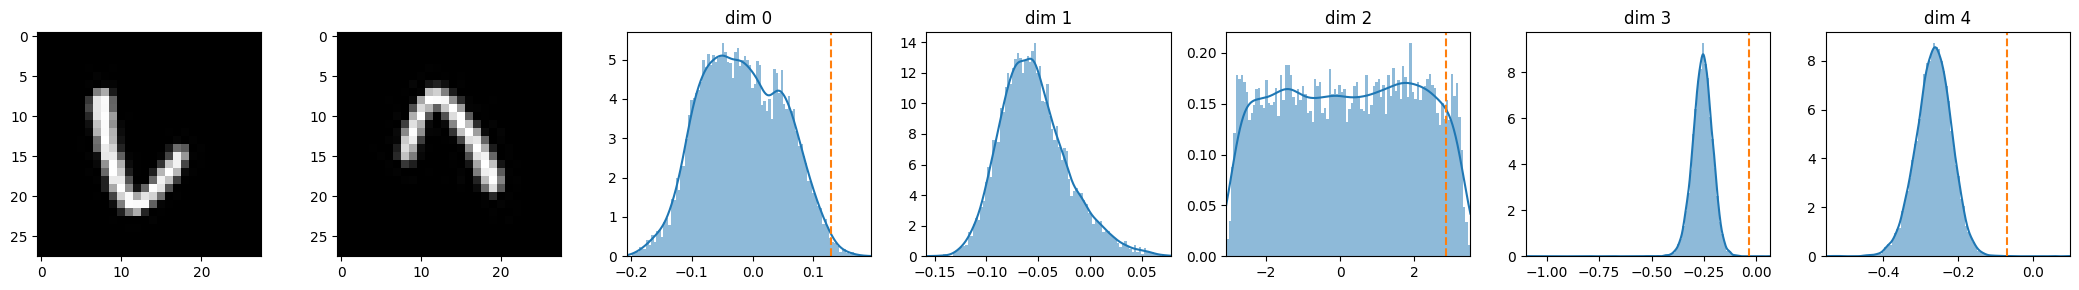

In [54]:
full_mask = jnp.array([1, 1, 1, 1, 1])
rot_mask = jnp.array([0, 0, 1, 0, 0])
transformed_xs = jax.vmap(transform_image, in_axes=(None, 0))(
    x_,
    jnp.concatenate((
        jnp.linspace(-jnp.array(config.augment_bounds) * rot_mask, jnp.array(config.augment_bounds) * rot_mask, 4)[:3],
        jnp.linspace(-jnp.array(config.augment_bounds) * full_mask, jnp.array(config.augment_bounds) * full_mask, 3),
    ))
)

for x in transformed_xs:
    plot_hists(x, n=1_000)

[]

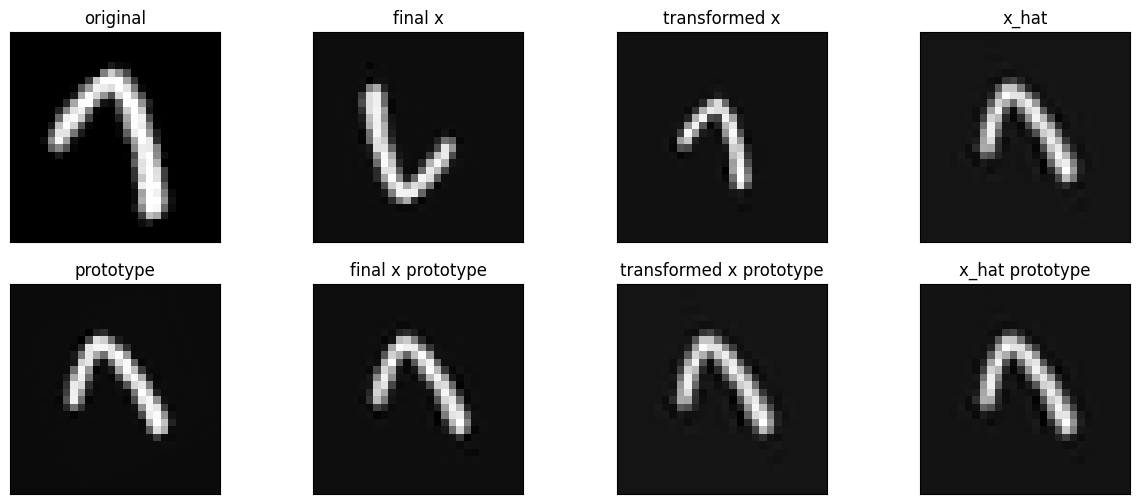

In [55]:
# make a figure with 2 rows and 4 columns
fig, axs = plt.subplots(2, 4, figsize=(15, 6))

# plot the original image
axs[0, 0].imshow(x_, cmap='gray')
axs[0, 0].set_title("original")
axs[0, 0].set_xticks([])
axs[0, 0].set_yticks([])

# plot the corresponding prototype
xhat, η = get_prototype(x_)
axs[1, 0].imshow(xhat, cmap='gray')
axs[1, 0].set_title("prototype")
axs[1, 0].set_xticks([])
axs[1, 0].set_yticks([])

# plot x
axs[0, 1].imshow(x, cmap='gray')
axs[0, 1].set_title("final x")
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])

# plot the corresponding prototype
xhat, η = get_prototype(x)
axs[1, 1].imshow(xhat, cmap='gray')
axs[1, 1].set_title("final x prototype")
axs[1, 1].set_xticks([])
axs[1, 1].set_yticks([])

# transform again and plot the result
xx = transform_image(x, jnp.array(config.augment_bounds))
axs[0, 2].imshow(xx, cmap='gray')
axs[0, 2].set_title("transformed x")
axs[0, 2].set_xticks([])
axs[0, 2].set_yticks([])

# plot the corresponding prototype
xhat, η = get_prototype(xx)
axs[1, 2].imshow(xhat, cmap='gray')
axs[1, 2].set_title("transformed x prototype")
axs[1, 2].set_xticks([])
axs[1, 2].set_yticks([])

# use that xhat as x
axs[0, 3].imshow(xhat, cmap='gray')
axs[0, 3].set_title("x_hat")
axs[0, 3].set_xticks([])
axs[0, 3].set_yticks([])

# plot the corresponding prototype
xhat, η = get_prototype(xhat)
axs[1, 3].imshow(xhat, cmap='gray')
axs[1, 3].set_title("x_hat prototype")
axs[1, 3].set_xticks([])
axs[1, 3].set_yticks([])
